# Домашнее задание к занятию «Улучшение качества обучения нейросети»

Задание:
На примере датасета персонажей мультфильма Симпсонов:

1.   Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
2.   Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
3.  Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
4. Оформите вывод по результатам проведённых экспериментов.

# Загрузка библиотек

In [1]:
import os
import glob
import shutil
import time

In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from collections import defaultdict

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models import mobilenet_v2
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from IPython.display import clear_output

In [5]:
from numba import cuda

# Параметры GPU

In [6]:
print(f"CUDA поддерживается системой?")
if torch.cuda.is_available() == True:
    print(f"CUDA-версия: {torch.version.cuda}")
    cuda_id = torch.cuda.current_device()
    print(f"ID текущего CUDA устройства:{torch.cuda.current_device()}")
    print(f"Имя текущего CUDA устройства:{torch.cuda.get_device_name(cuda_id)}")
else:
    print(f"Нет")

CUDA поддерживается системой?
CUDA-версия: 11.8
ID текущего CUDA устройства:0
Имя текущего CUDA устройства:NVIDIA GeForce RTX 2060


# Выбор процессора

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Вводные параметры

In [8]:
input_size = 224
batch_size = 64
num_epochs = 5
learning_rate = 0.01

# Подключение Drive

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

# Загрузка данных

In [10]:
# for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/kaggle/simpsons/original/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [11]:
# shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/kaggle/simpsons/original/input/archive.zip', '/content/drive/MyDrive/Colab Notebooks/kaggle/simpsons/original')

In [12]:
data_dir = "./simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*")

In [13]:
len(data_image_paths)

42

# Функции

## Отображение

In [14]:
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

## Точность

In [15]:
def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

## Аугментация

In [16]:
def prepare_datasets(data_dir, train_augmentations=None, val_augmentations=None):
    data_paths = glob.glob(f"{data_dir}/*")
    data_image_paths = []
    data_image_labels = []
    for name in data_paths:
        if check_folder(name):
            data_image_paths += glob.glob(f"{name}/*.jpg")
        else:
            print(name)
            os.rmdir(name)
    data_image_labels = [path.split('/')[-2] for path in data_image_paths]
    print(len(data_image_paths), len(data_image_labels))
    train_files_path, val_files_path = train_test_split(
        data_image_paths,
        test_size=0.3,
        stratify=data_image_labels
    )

    print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")
    input_size = 224
    if train_augmentations is not None:
        train_transform = transforms.Compose(train_augmentations)
    else:
        train_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])
    if val_augmentations is not None:
        val_transform = transforms.Compose(val_augmentations)
    else:
        val_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])

    train_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=train_transform,
          is_valid_file=lambda x: x in train_files_path
      )

    val_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=val_transform,
          is_valid_file=lambda x: x in val_files_path
      )
    return train_dataset, val_dataset

## Обучение

In [17]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    schedulers=None, names=None
):
    times = []
    l_rates = []
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        model.train(True)

        # в каждой эпохе полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        model.train(False)

        # полный проход по валидационным данным
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()
        epoch_time = time.time() - start_time

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, epoch_time))
        times.append(epoch_time)
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

        if schedulers is not None:
            for scheduler, name in zip(schedulers, names):
                if name == 'ReduceLROnPlateau':
                    scheduler.step(val_loss)
                else:
                    scheduler.step()
                    l_rates.append(scheduler.get_last_lr())
        else:
            l_rates.append(learning_rate)
    return model, history, times, l_rates

## Дообучение

In [18]:
def fine_tuning(schedulers, name):
    fine_tuning_model = nn.Sequential()

    fine_tuning_model.add_module('resnet', torchvision.models.resnet18(pretrained=True))

    # добавим новые слои для классификации для нашей конкретной задачи
    fine_tuning_model.add_module('relu_1', nn.ReLU())
    fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
    fine_tuning_model.add_module('relu_2', nn.ReLU())
    fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

    fine_tuning_model = fine_tuning_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

    clf_model, history, times = train(
      fine_tuning_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, name
    )
    return clf_model, history, times

## Проверка пути

In [19]:
def check_folder(name):
    folder_contents = os.listdir(name)
    if len(folder_contents) > 0:
        return True
    else:
        return False

# Варианты Аугментации

In [20]:
train_augmentations  = []
val_augmentations = []

# 'base' - Параметры Аугментации стандартные для train
train_augmentations_base = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ToTensor(),
  ]
# 'Good' - Параметры улучшающей Аугментацию для train
train_augmentations_good = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
  ]
# 'Bad' - Параметры ухудшающие Аугментацию для train
train_augmentations_bad = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ElasticTransform(alpha=250.0),
      transforms.ToTensor(),
  ]
train_augmentations.append(('base', train_augmentations_base))
train_augmentations.append(('Good', train_augmentations_good))
train_augmentations.append(('Bad', train_augmentations_bad))

# 'Base' - Параметры Аугментации стандартные для val
val_augmentations_base = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
# 'Good' - Параметры улучшающей Аугментацию для val
val_augmentations_good = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
# 'Bad' - Параметры ухудшающие Аугментацию для val
val_augmentations_bad = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
val_augmentations.append(('base', val_augmentations_base))
val_augmentations.append(('Good', val_augmentations_good))
val_augmentations.append(('Bad', val_augmentations_bad))

# Обучение

In [21]:
result = pd.DataFrame(columns=['model','augmentation', 'sheduler','time', 'lr', 'epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

In [22]:
results = dict()

## Base Аугментация



### Подготовка данных

In [23]:
train_dataset, val_dataset = prepare_datasets(data_dir)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


In [24]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


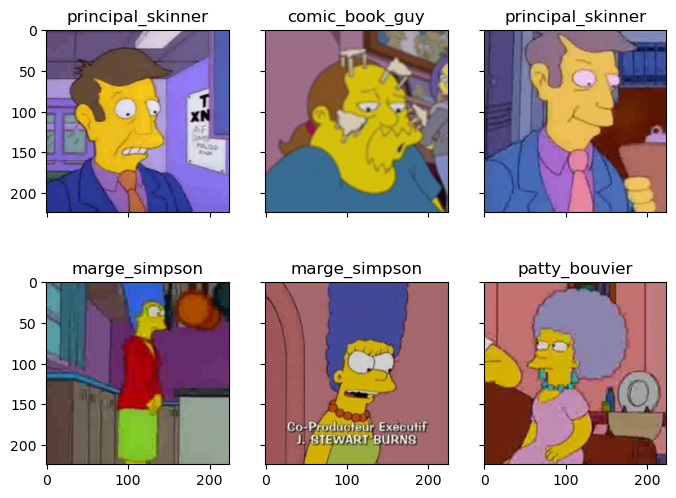

In [25]:
show_images(val_dataset)

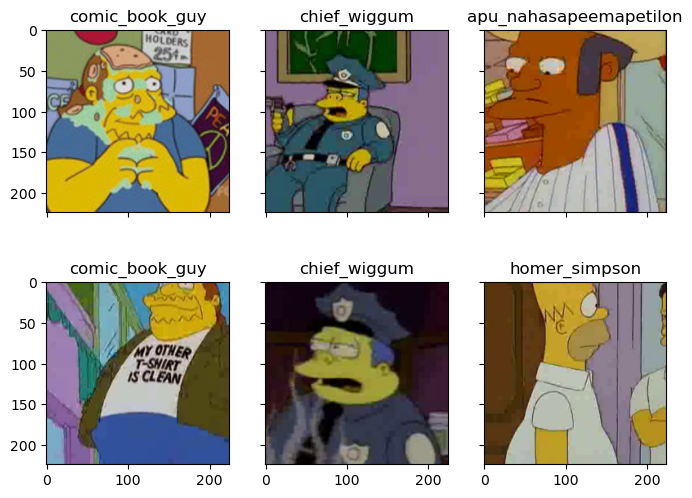

In [26]:
show_images(train_dataset)

In [27]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Обучение с нуля

Epoch 5 of 5 took 262.394s
  training loss (in-iteration): 	1.222008
  validation loss (in-iteration): 	1.536222
  training accuracy: 			68.46 %
  validation accuracy: 			59.09 %


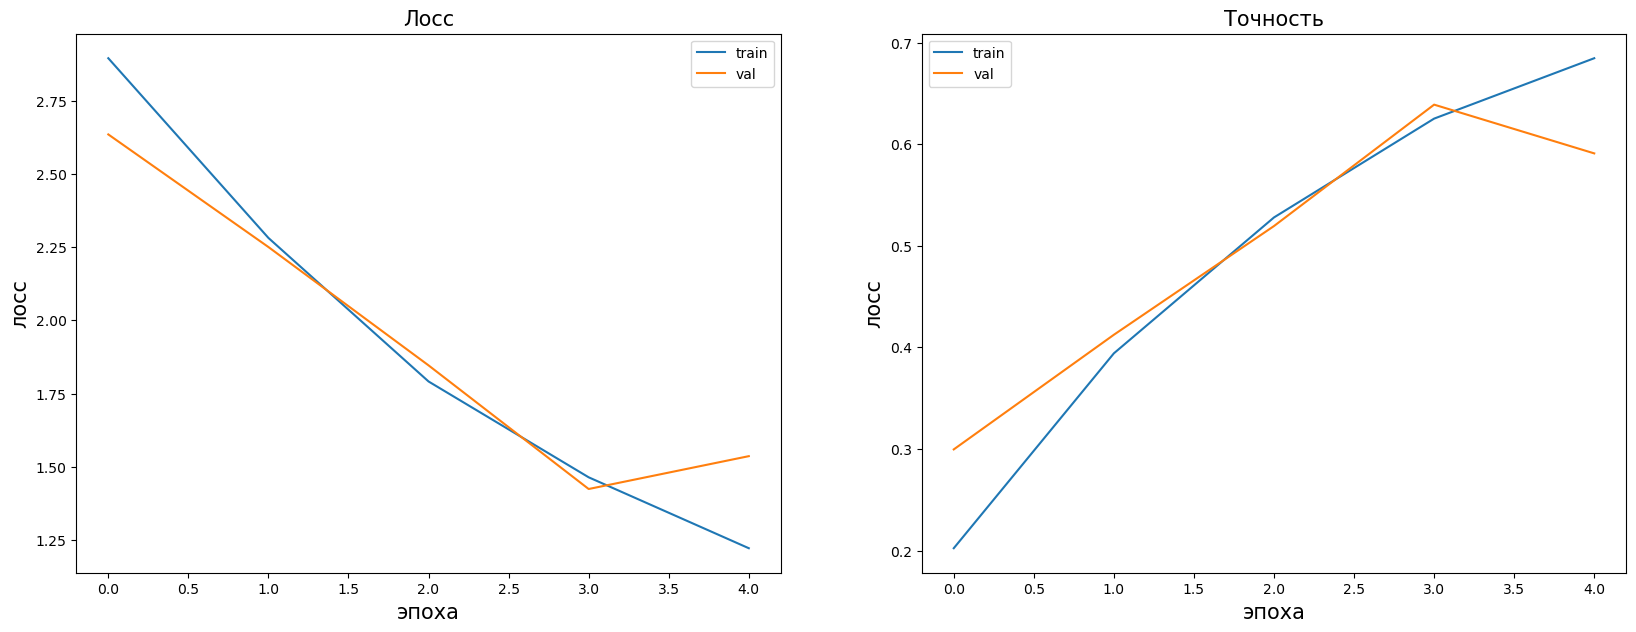

In [28]:
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None
  )
results['None'] = history

In [29]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['с нуля','base', 'None', times[i], l_rates[i], i, results['None']['loss']['train'][i], results['None']['acc']['train'][i], results['None']['loss']['val'][i], results['None']['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
3,с нуля,base,None,342.453991,0.01,3,1.464051,0.625141,1.424121,0.638889
4,с нуля,base,None,262.393738,0.01,4,1.222008,0.684577,1.536222,0.590909
2,с нуля,base,None,295.254007,0.01,2,1.791136,0.527884,1.846103,0.519413
1,с нуля,base,None,270.618987,0.01,1,2.281090,0.394127,2.249993,0.412405
0,с нуля,base,None,253.791587,0.01,0,2.894439,0.202302,2.634354,0.299558


#### С нуля с Scheduler = 'Multistep'

Epoch 5 of 5 took 454.244s
  training loss (in-iteration): 	2.240460
  validation loss (in-iteration): 	2.275616
  training accuracy: 			41.65 %
  validation accuracy: 			41.67 %


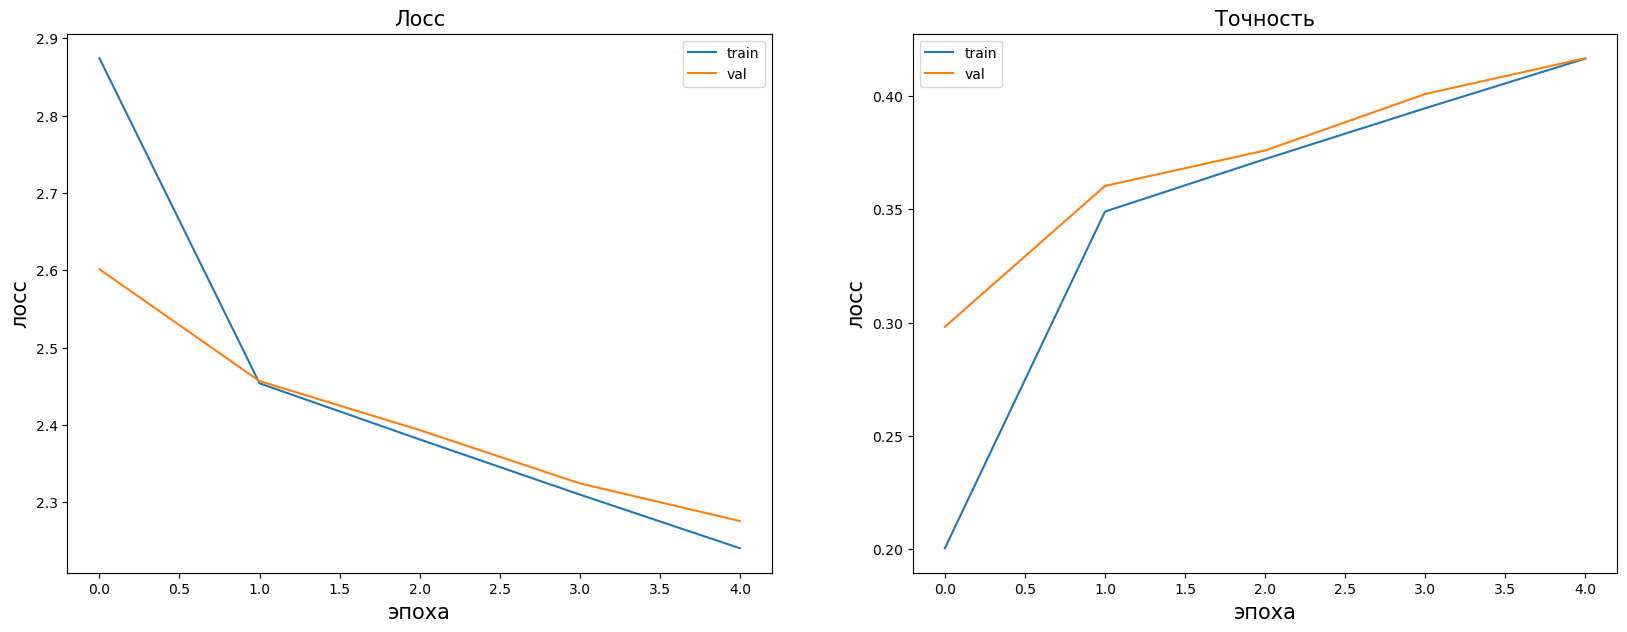

In [33]:
name = 'MultiStep'
names = ['MultiStep']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)

clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [34]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['с нуля','base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
3,с нуля,base,None,342.453991,0.01,3,1.464051,0.625141,1.424121,0.638889
4,с нуля,base,None,262.393738,0.01,4,1.222008,0.684577,1.536222,0.590909
2,с нуля,base,None,295.254007,0.01,2,1.791136,0.527884,1.846103,0.519413
9,с нуля,base,MultiStep,454.243719,[0.001],4,2.240460,0.416507,2.275616,0.416667
1,с нуля,base,None,270.618987,0.01,1,2.281090,0.394127,2.249993,0.412405
8,с нуля,base,MultiStep,463.334135,[0.001],3,2.309837,0.394605,2.324316,0.400884
7,с нуля,base,MultiStep,448.735342,[0.001],2,2.381154,0.372157,2.393243,0.375947
6,с нуля,base,MultiStep,446.490466,[0.001],1,2.453709,0.348993,2.456577,0.360322
0,с нуля,base,None,253.791587,0.01,0,2.894439,0.202302,2.634354,0.299558
5,с нуля,base,MultiStep,453.946458,[0.001],0,2.874099,0.200449,2.601239,0.298138


#### С нуля с Scheduler = 'Multistep' + 'ReduceLROnPlateau'

Epoch 5 of 5 took 451.963s
  training loss (in-iteration): 	2.353891
  validation loss (in-iteration): 	2.383574
  training accuracy: 			38.88 %
  validation accuracy: 			38.62 %


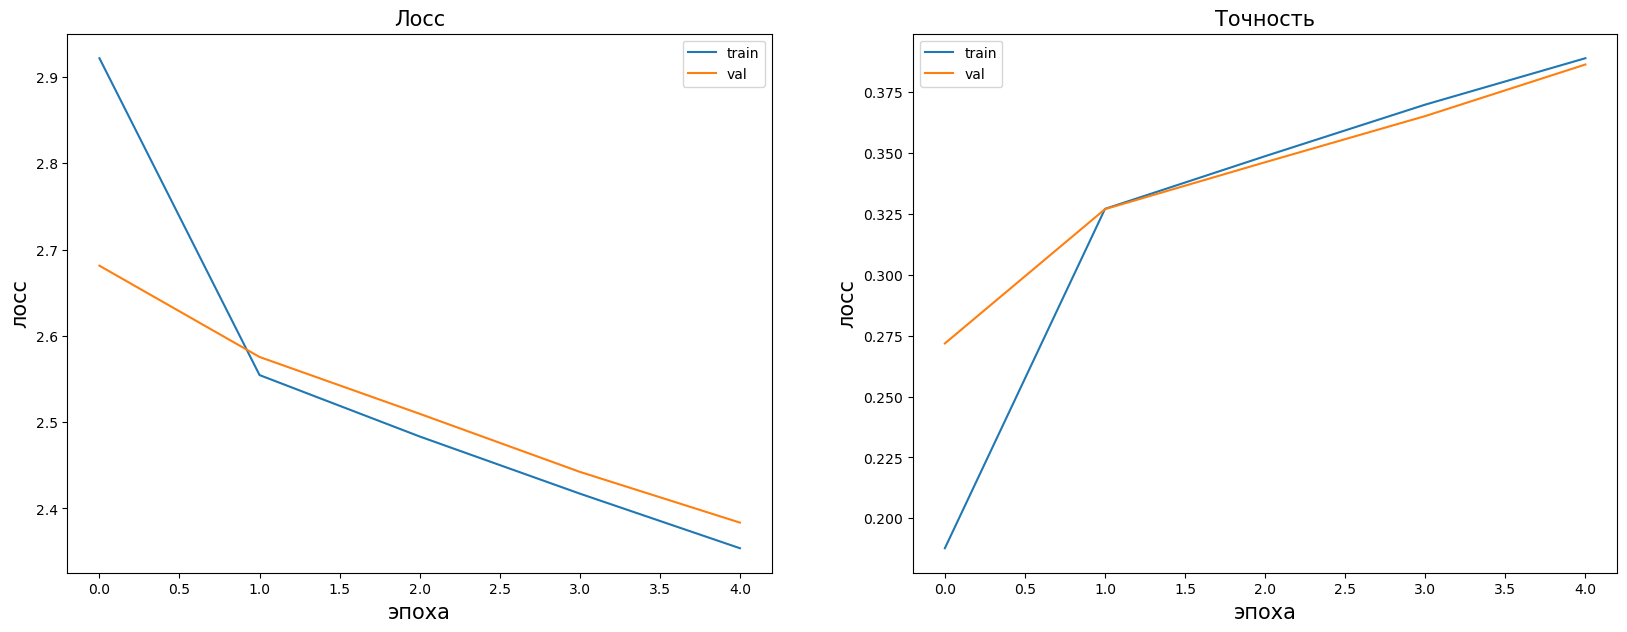

In [36]:
name = 'M&R'
names = ['MultiStep', 'ReduceLROnPlateau']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [37]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['с нуля','base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
3,с нуля,base,None,342.453991,0.01,3,1.464051,0.625141,1.424121,0.638889
4,с нуля,base,None,262.393738,0.01,4,1.222008,0.684577,1.536222,0.590909
2,с нуля,base,None,295.254007,0.01,2,1.791136,0.527884,1.846103,0.519413
9,с нуля,base,MultiStep,454.243719,[0.001],4,2.240460,0.416507,2.275616,0.416667
1,с нуля,base,None,270.618987,0.01,1,2.281090,0.394127,2.249993,0.412405
8,с нуля,base,MultiStep,463.334135,[0.001],3,2.309837,0.394605,2.324316,0.400884
14,с нуля,base,M&R,451.962821,[0.001],4,2.353891,0.388788,2.383574,0.386206
7,с нуля,base,MultiStep,448.735342,[0.001],2,2.381154,0.372157,2.393243,0.375947
13,с нуля,base,M&R,441.944616,[0.001],3,2.417171,0.369752,2.442394,0.365057
6,с нуля,base,MultiStep,446.490466,[0.001],1,2.453709,0.348993,2.456577,0.360322


### Обучение с Future Extraction

Epoch 5 of 5 took 438.403s
  training loss (in-iteration): 	1.356173
  validation loss (in-iteration): 	1.404359
  training accuracy: 			69.68 %
  validation accuracy: 			67.22 %


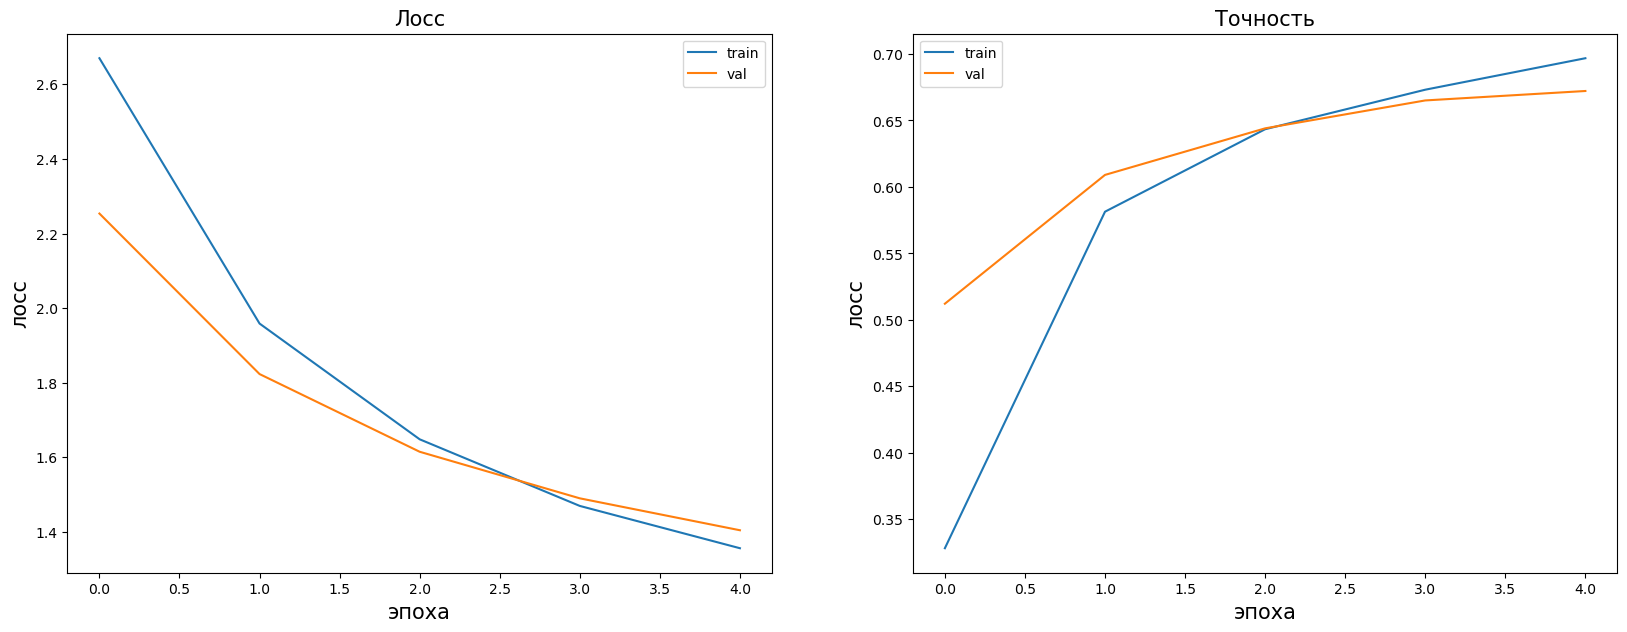

In [39]:
name = 'None'
fe_model = torchvision.models.resnet18(pretrained=True)
for param in fe_model.parameters():
    param.requires_grad = False
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

In [40]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['feature_extractor','base', 'None', times[i], l_rates[i], i, results['None']['loss']['train'][i], results['None']['acc']['train'][i], results['None']['loss']['val'][i], results['None']['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
19,feature_extractor,base,None,438.403252,0.01,4,1.356173,0.696849,1.404359,0.672191
18,feature_extractor,base,None,439.443928,0.01,3,1.469579,0.673166,1.489952,0.665088
17,feature_extractor,base,None,444.811943,0.01,2,1.648220,0.643424,1.614833,0.644097
3,с нуля,base,None,342.453991,0.01,3,1.464051,0.625141,1.424121,0.638889
16,feature_extractor,base,None,621.038476,0.01,1,1.958613,0.581384,1.823178,0.609059
4,с нуля,base,None,262.393738,0.01,4,1.222008,0.684577,1.536222,0.590909
2,с нуля,base,None,295.254007,0.01,2,1.791136,0.527884,1.846103,0.519413
15,feature_extractor,base,None,443.256151,0.01,0,2.670043,0.328199,2.253574,0.512153
9,с нуля,base,MultiStep,454.243719,[0.001],4,2.240460,0.416507,2.275616,0.416667
1,с нуля,base,None,270.618987,0.01,1,2.281090,0.394127,2.249993,0.412405


#### Future Extraction с Scheduler = 'Multistep'

Epoch 5 of 5 took 436.623s
  training loss (in-iteration): 	1.355272
  validation loss (in-iteration): 	1.414618
  training accuracy: 			69.06 %
  validation accuracy: 			67.68 %


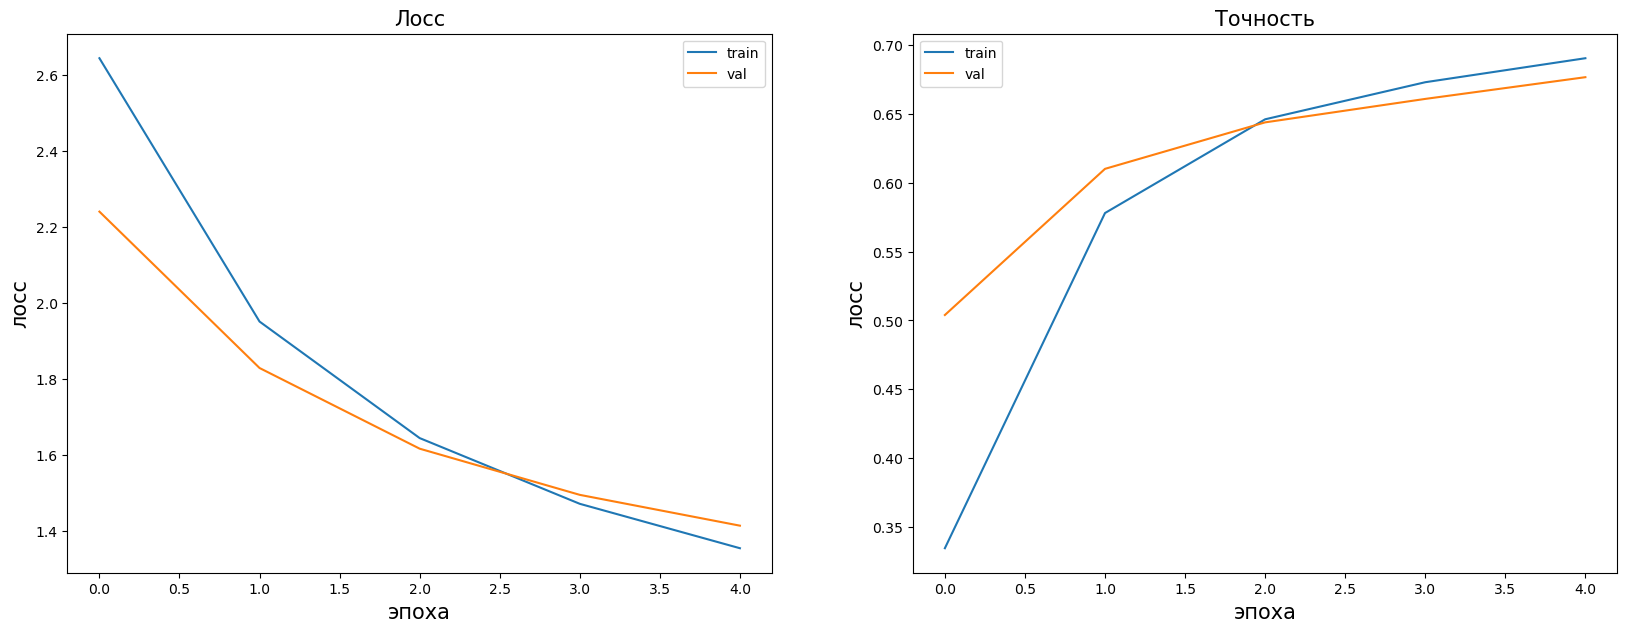

In [42]:
name = 'Multistep'
names = ['MultiStep']
fe_model = torchvision.models.resnet18(pretrained=True)
for param in fe_model.parameters():
    param.requires_grad = False

fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
schedulers =[]
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [43]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['feature_extractor','base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results['None']['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
24,feature_extractor,base,Multistep,436.622976,[0.0001],4,1.355272,0.690551,1.404359,0.676768
19,feature_extractor,base,None,438.403252,0.01,4,1.356173,0.696849,1.404359,0.672191
18,feature_extractor,base,None,439.443928,0.01,3,1.469579,0.673166,1.489952,0.665088
23,feature_extractor,base,Multistep,440.338195,[0.0001],3,1.472129,0.673111,1.489952,0.660985
17,feature_extractor,base,None,444.811943,0.01,2,1.648220,0.643424,1.614833,0.644097
22,feature_extractor,base,Multistep,438.148774,[0.0001],2,1.645075,0.646166,1.614833,0.643939
3,с нуля,base,None,342.453991,0.01,3,1.464051,0.625141,1.424121,0.638889
21,feature_extractor,base,Multistep,439.626789,[0.0001],1,1.951718,0.578051,1.823178,0.610164
16,feature_extractor,base,None,621.038476,0.01,1,1.958613,0.581384,1.823178,0.609059
4,с нуля,base,None,262.393738,0.01,4,1.222008,0.684577,1.536222,0.590909


#### Future Extraction с Scheduler = 'Multistep' + 'ReduceLROnPlateau'

Epoch 5 of 5 took 437.266s
  training loss (in-iteration): 	1.981706
  validation loss (in-iteration): 	2.031642
  training accuracy: 			59.01 %
  validation accuracy: 			57.15 %


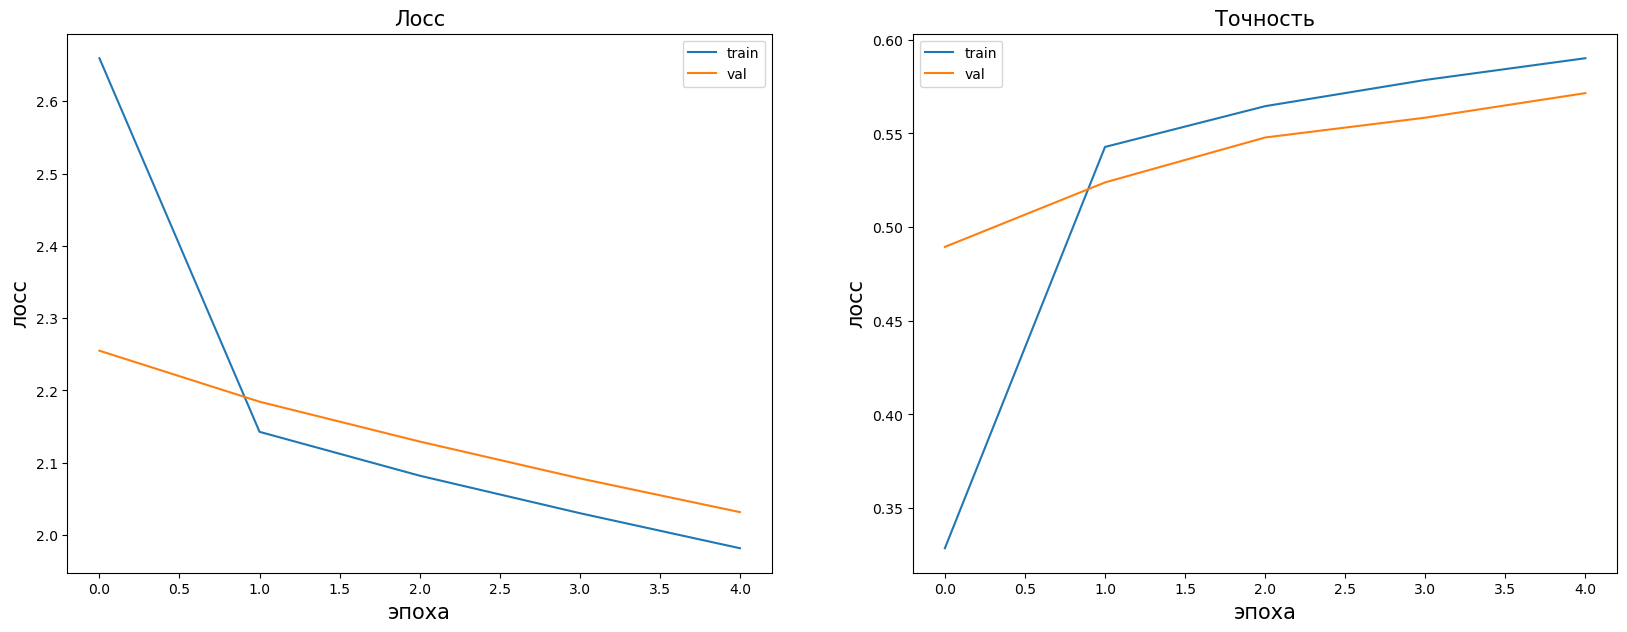

In [45]:
name = 'M&R'
names = ['MultiStep', 'ReduceLROnPlateau']
schedulers=[]
fe_model = torchvision.models.resnet18(pretrained=True)
for param in fe_model.parameters():
    param.requires_grad = False
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs,  schedulers, names
  )
results[name] = history

In [46]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['feature_extractor','base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
24,feature_extractor,base,Multistep,436.622976,[0.0001],4,1.355272,0.690551,1.404359,0.676768
19,feature_extractor,base,None,438.403252,0.01,4,1.356173,0.696849,1.404359,0.672191
18,feature_extractor,base,None,439.443928,0.01,3,1.469579,0.673166,1.489952,0.665088
23,feature_extractor,base,Multistep,440.338195,[0.0001],3,1.472129,0.673111,1.489952,0.660985
17,feature_extractor,base,None,444.811943,0.01,2,1.648220,0.643424,1.614833,0.644097
22,feature_extractor,base,Multistep,438.148774,[0.0001],2,1.645075,0.646166,1.614833,0.643939
3,с нуля,base,None,342.453991,0.01,3,1.464051,0.625141,1.424121,0.638889
21,feature_extractor,base,Multistep,439.626789,[0.0001],1,1.951718,0.578051,1.823178,0.610164
16,feature_extractor,base,None,621.038476,0.01,1,1.958613,0.581384,1.823178,0.609059
4,с нуля,base,None,262.393738,0.01,4,1.222008,0.684577,1.536222,0.590909


### Обучение с Fine-tuning

Epoch 5 of 5 took 446.428s
  training loss (in-iteration): 	0.119033
  validation loss (in-iteration): 	0.288926
  training accuracy: 			97.38 %
  validation accuracy: 			92.88 %


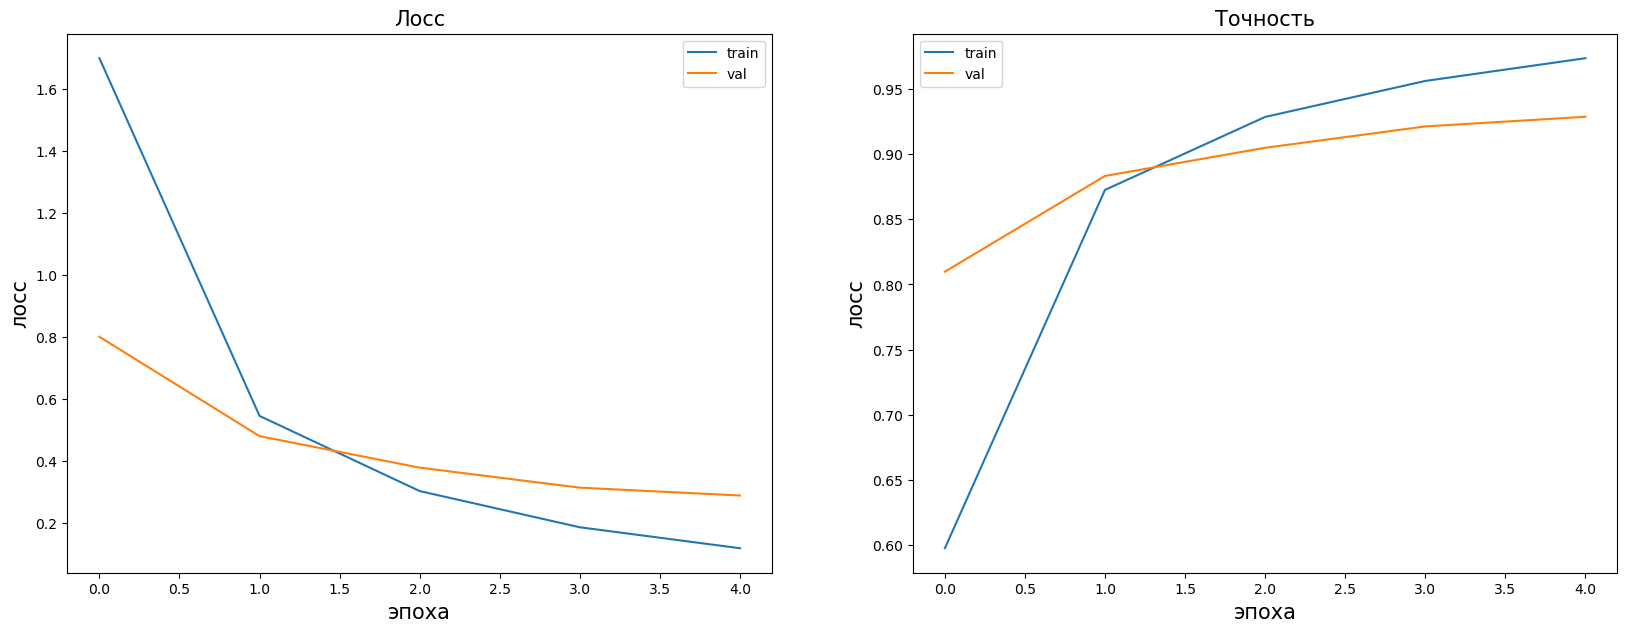

In [48]:
name = 'None'
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs, schedulers=None, names=None
)
results[name] = history

In [49]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['fine_tuning','base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
31,fine_tuning,base,None,444.970593,0.01,1,0.545257,0.872657,0.480079,0.883365
30,fine_tuning,base,None,442.428328,0.01,0,1.697653,0.597401,0.800152,0.809817
24,feature_extractor,base,Multistep,436.622976,[0.0001],4,1.355272,0.690551,1.404359,0.676768
19,feature_extractor,base,None,438.403252,0.01,4,1.356173,0.696849,1.404359,0.672191
18,feature_extractor,base,None,439.443928,0.01,3,1.469579,0.673166,1.489952,0.665088
23,feature_extractor,base,Multistep,440.338195,[0.0001],3,1.472129,0.673111,1.489952,0.660985
17,feature_extractor,base,None,444.811943,0.01,2,1.648220,0.643424,1.614833,0.644097


#### Fine-tuning с Scheduler = 'Multistep'

Epoch 5 of 5 took 441.499s
  training loss (in-iteration): 	0.527533
  validation loss (in-iteration): 	0.619219
  training accuracy: 			88.02 %
  validation accuracy: 			85.10 %


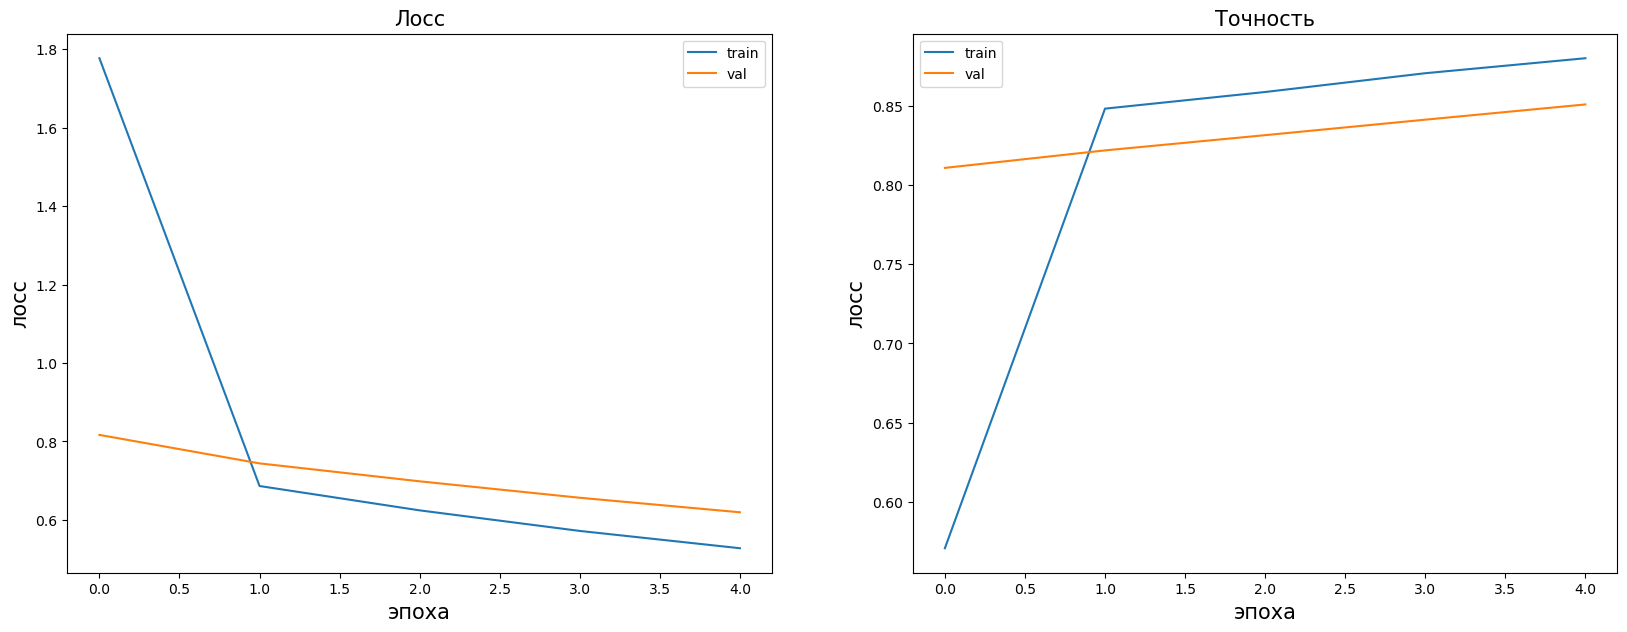

In [51]:
name = 'Multistep'
names = ['Multistep']
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
schedulers =[]
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs, schedulers, names
)
results[name] = history

In [52]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['fine_tuning','base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
31,fine_tuning,base,None,444.970593,0.01,1,0.545257,0.872657,0.480079,0.883365
39,fine_tuning,base,Multistep,441.499201,[0.001],4,0.527533,0.880217,0.619219,0.851010
38,fine_tuning,base,Multistep,444.238466,[0.001],3,0.571628,0.870739,0.656265,0.841383
37,fine_tuning,base,Multistep,444.162689,[0.001],2,0.624092,0.858871,0.698202,0.831597
36,fine_tuning,base,Multistep,445.842199,[0.001],1,0.686206,0.848356,0.743927,0.821970
35,fine_tuning,base,Multistep,443.054656,[0.001],0,1.777440,0.570579,0.816616,0.810922
30,fine_tuning,base,None,442.428328,0.01,0,1.697653,0.597401,0.800152,0.809817


#### Fine-tuning с Scheduler = 'Multistep' + 'ReduceLROnPlateau'

Epoch 5 of 5 took 444.375s
  training loss (in-iteration): 	0.113168
  validation loss (in-iteration): 	0.290072
  training accuracy: 			97.51 %
  validation accuracy: 			92.87 %


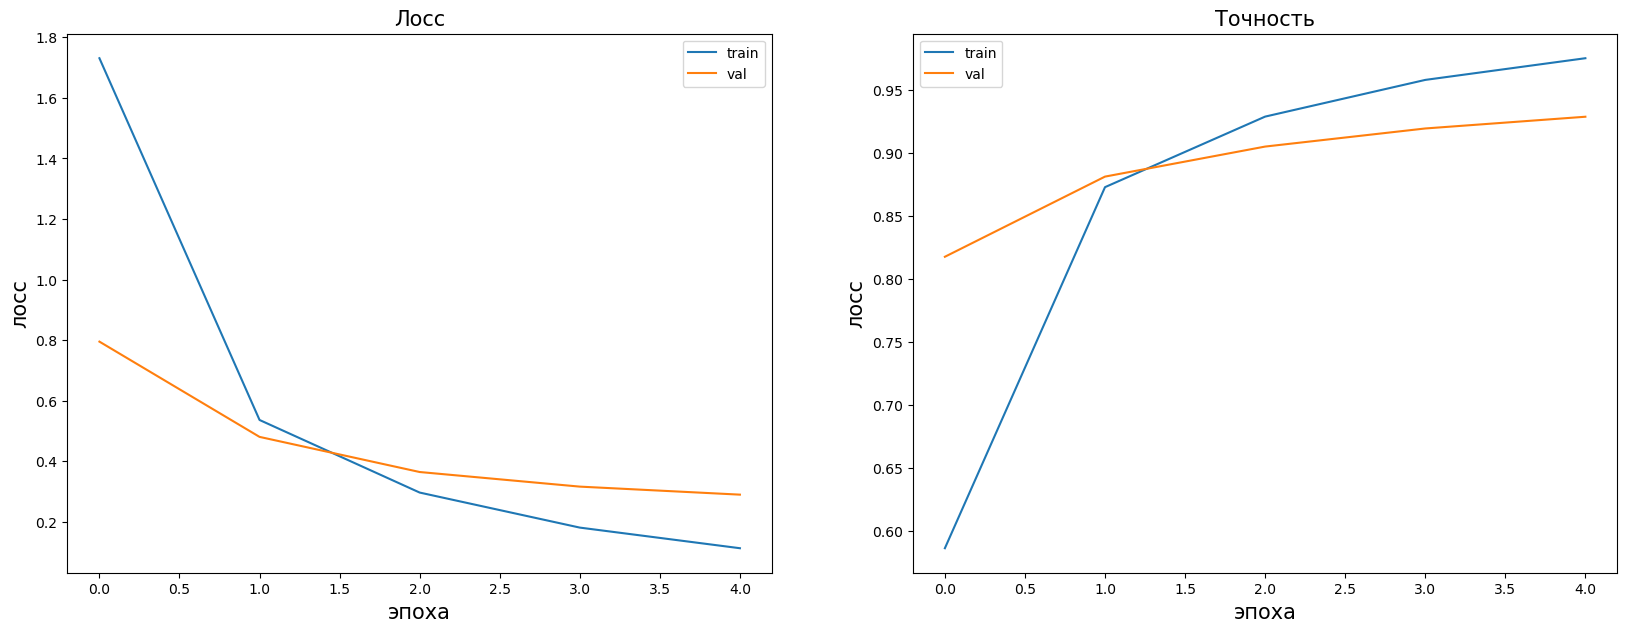

In [54]:
name = 'M&R'
names = ['MultiStep', 'ReduceLROnPlateau']
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs, schedulers, names
)
results[name] = history

In [55]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['fine_tuning','base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
44,fine_tuning,base,M&R,444.375121,[0.0001],4,0.113168,0.975092,0.290072,0.928662
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
43,fine_tuning,base,M&R,441.148812,[0.0001],3,0.181254,0.957884,0.316561,0.919350
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
42,fine_tuning,base,M&R,441.713238,[0.0001],2,0.296949,0.928763,0.364779,0.904987
31,fine_tuning,base,None,444.970593,0.01,1,0.545257,0.872657,0.480079,0.883365
41,fine_tuning,base,M&R,440.892043,[0.0001],1,0.536603,0.872783,0.480771,0.881155
39,fine_tuning,base,Multistep,441.499201,[0.001],4,0.527533,0.880217,0.619219,0.851010
38,fine_tuning,base,Multistep,444.238466,[0.001],3,0.571628,0.870739,0.656265,0.841383


### Итоги Base Aug

Самая высокая точность у модели с fine_tuning, при этом применение шедулера не приводит к существенному улучшению.

## Good Аугментация

### Подготовка данных

In [60]:
train_dataset, val_dataset = prepare_datasets(data_dir, train_augmentations_good,val_augmentations_good)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


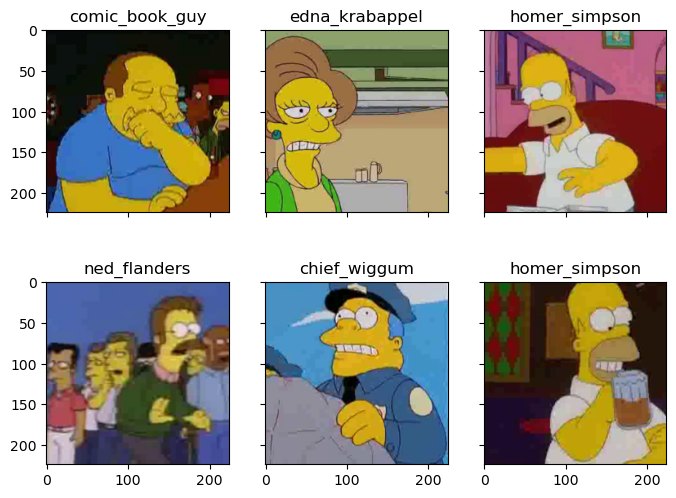

In [61]:
show_images(val_dataset)

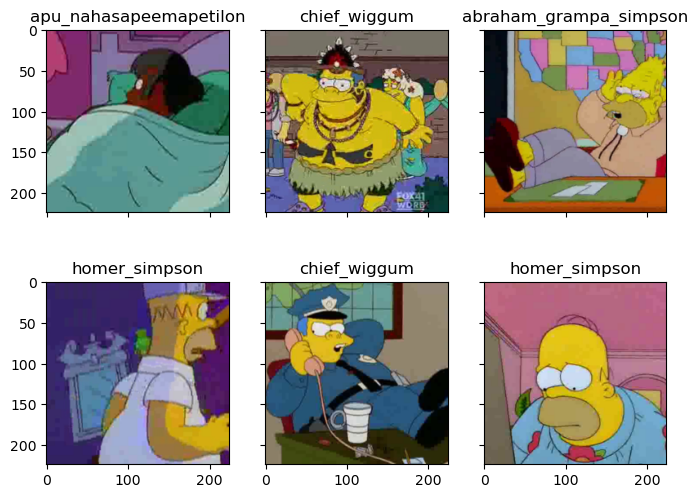

In [62]:
show_images(train_dataset)

In [63]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Обучение с нуля

Epoch 5 of 5 took 489.944s
  training loss (in-iteration): 	1.224317
  validation loss (in-iteration): 	1.452593
  training accuracy: 			68.78 %
  validation accuracy: 			60.78 %


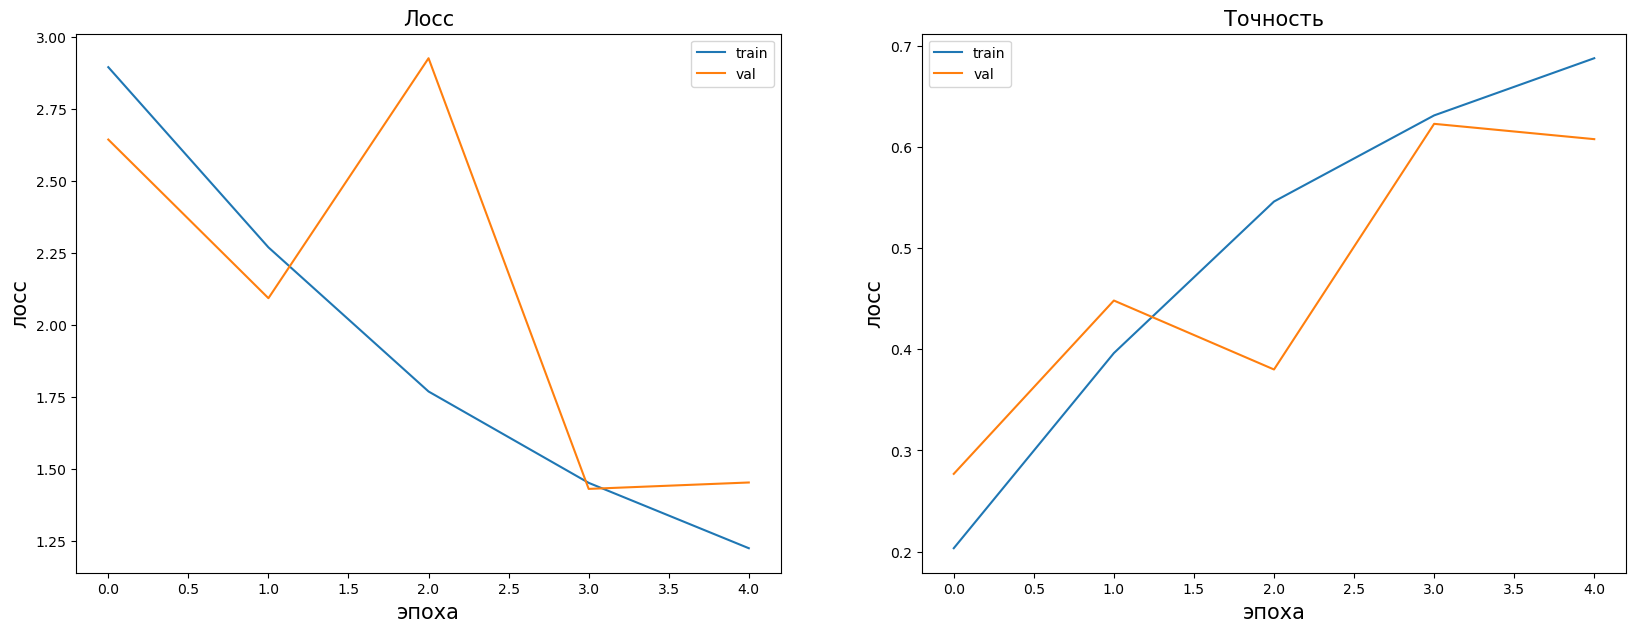

In [65]:
criterion = nn.CrossEntropyLoss()
name='None'
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results['None'] = history

In [66]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['С нуля','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
    result.sort_values(by='val_accuracy', ascending=False)

### Обучение с Future Extraction

Epoch 5 of 5 took 452.586s
  training loss (in-iteration): 	1.376023
  validation loss (in-iteration): 	1.365274
  training accuracy: 			68.37 %
  validation accuracy: 			69.03 %


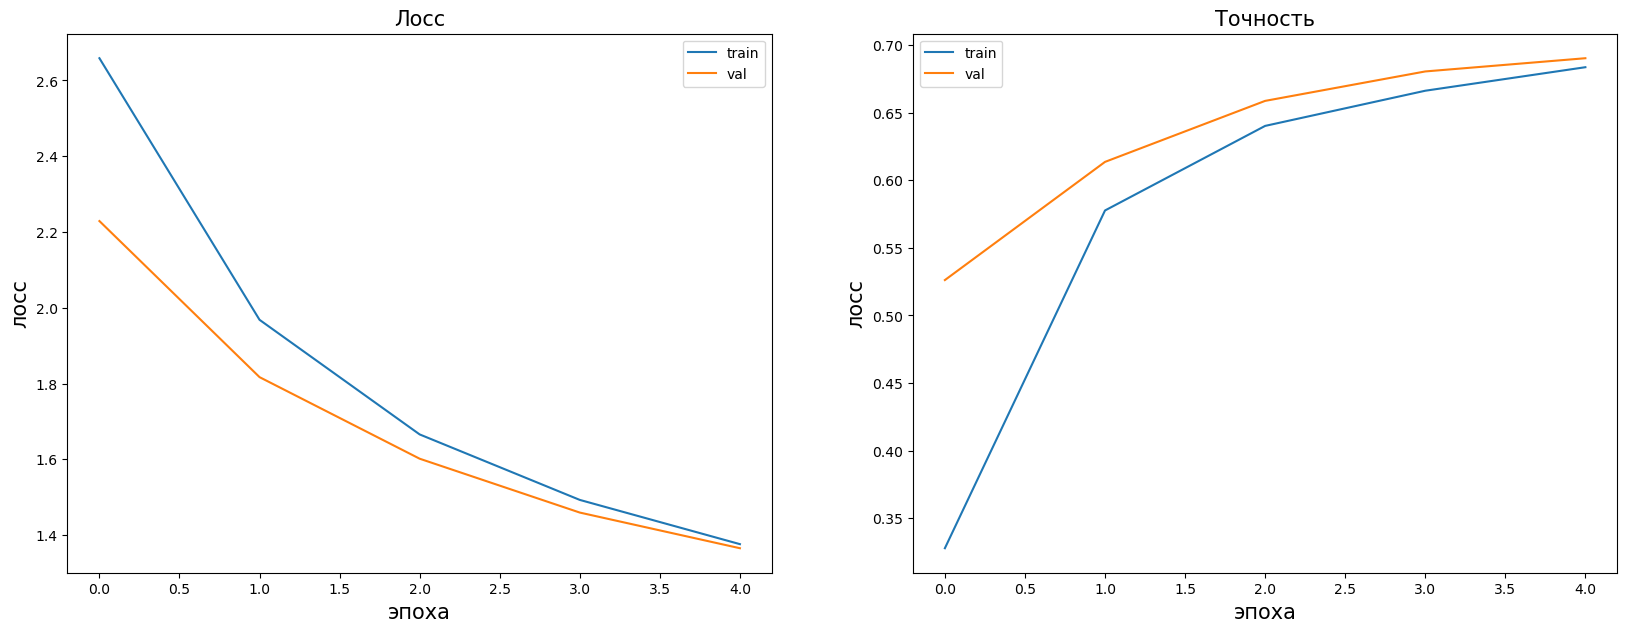

In [68]:
name = 'None'
fe_model = torchvision.models.resnet18(pretrained=True)
for param in fe_model.parameters():
    param.requires_grad = False

fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

In [69]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['features_extraction','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
44,fine_tuning,base,M&R,444.375121,[0.0001],4,0.113168,0.975092,0.290072,0.928662
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
43,fine_tuning,base,M&R,441.148812,[0.0001],3,0.181254,0.957884,0.316561,0.919350
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
42,fine_tuning,base,M&R,441.713238,[0.0001],2,0.296949,0.928763,0.364779,0.904987
31,fine_tuning,base,None,444.970593,0.01,1,0.545257,0.872657,0.480079,0.883365
41,fine_tuning,base,M&R,440.892043,[0.0001],1,0.536603,0.872783,0.480771,0.881155
39,fine_tuning,base,Multistep,441.499201,[0.001],4,0.527533,0.880217,0.619219,0.851010
38,fine_tuning,base,Multistep,444.238466,[0.001],3,0.571628,0.870739,0.656265,0.841383


### Обучение с Fine-tuning

Epoch 5 of 5 took 444.060s
  training loss (in-iteration): 	0.163123
  validation loss (in-iteration): 	0.261700
  training accuracy: 			96.21 %
  validation accuracy: 			93.64 %


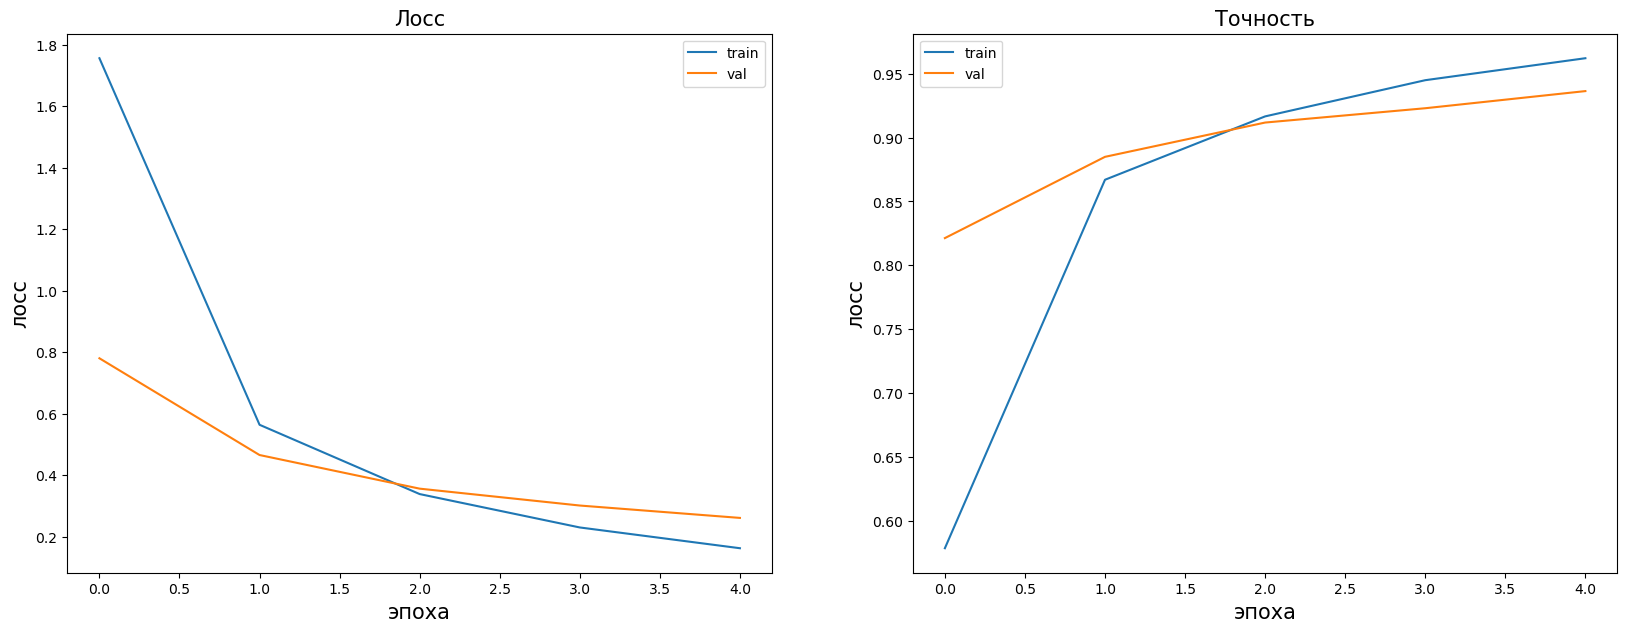

In [71]:
name='None'
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs, None, None
)
results[name] = history

In [72]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['fine_tuning','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
59,fine_tuning,good,None,444.059954,0.01,4,0.163123,0.962125,0.261700,0.936395
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
44,fine_tuning,base,M&R,444.375121,[0.0001],4,0.113168,0.975092,0.290072,0.928662
58,fine_tuning,good,None,445.321584,0.01,3,0.230634,0.944927,0.301961,0.922980
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
43,fine_tuning,base,M&R,441.148812,[0.0001],3,0.181254,0.957884,0.316561,0.919350
57,fine_tuning,good,None,444.435946,0.01,2,0.339216,0.916598,0.356834,0.911774
42,fine_tuning,base,M&R,441.713238,[0.0001],2,0.296949,0.928763,0.364779,0.904987
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
56,fine_tuning,good,None,496.342083,0.01,1,0.564541,0.867010,0.466197,0.884943


### Итоги Good Aug

Из good аугументации убраны лишние опции, что позволило улучшить качество модели.

## Bad Аугментация

### Подготовка данных

In [78]:
train_dataset, val_dataset = prepare_datasets(data_dir, train_augmentations_bad,val_augmentations_bad)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


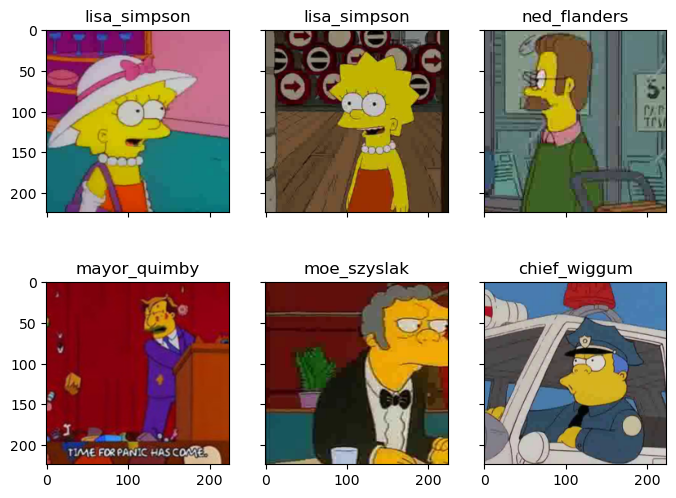

In [79]:
show_images(val_dataset)

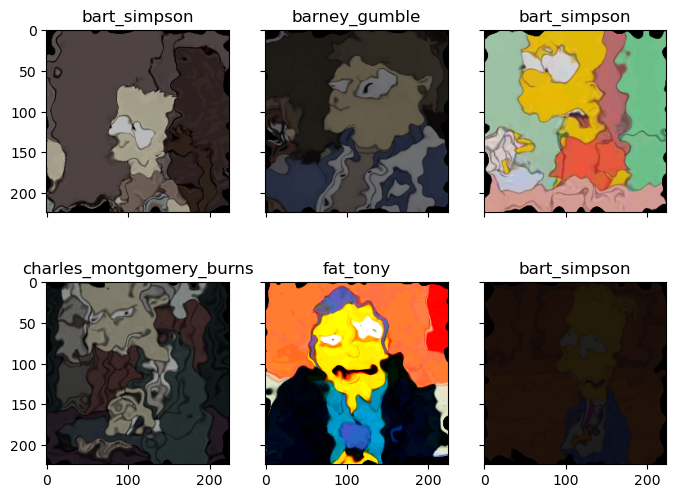

In [80]:
show_images(train_dataset)

In [81]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Обучение с нуля

Epoch 5 of 5 took 2097.318s
  training loss (in-iteration): 	2.703870
  validation loss (in-iteration): 	2.534091
  training accuracy: 			22.88 %
  validation accuracy: 			29.99 %


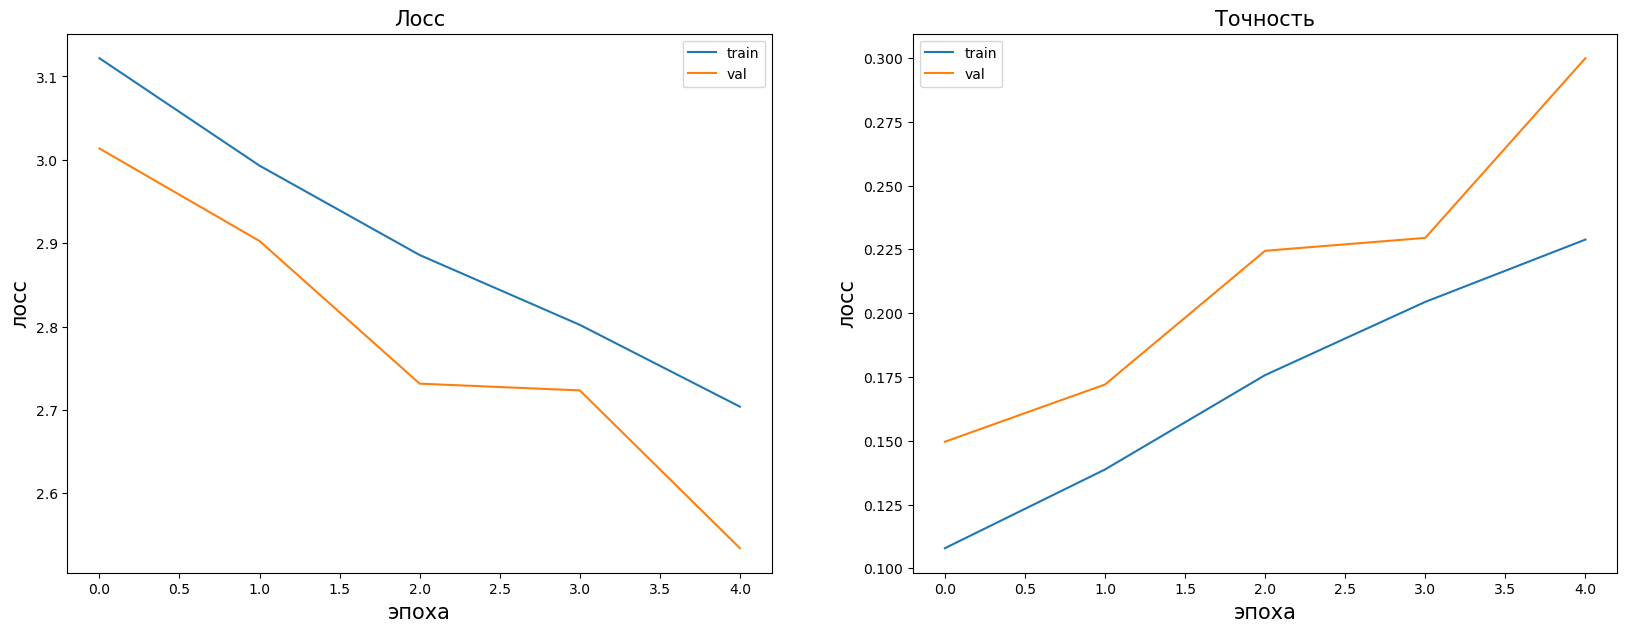

In [83]:
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None
  )
results['None'] = history

In [84]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['С нуля','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
59,fine_tuning,good,None,444.059954,0.01,4,0.163123,0.962125,0.261700,0.936395
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
44,fine_tuning,base,M&R,444.375121,[0.0001],4,0.113168,0.975092,0.290072,0.928662
58,fine_tuning,good,None,445.321584,0.01,3,0.230634,0.944927,0.301961,0.922980
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
43,fine_tuning,base,M&R,441.148812,[0.0001],3,0.181254,0.957884,0.316561,0.919350
57,fine_tuning,good,None,444.435946,0.01,2,0.339216,0.916598,0.356834,0.911774
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
42,fine_tuning,base,M&R,441.713238,[0.0001],2,0.296949,0.928763,0.364779,0.904987
56,fine_tuning,good,None,496.342083,0.01,1,0.564541,0.867010,0.466197,0.884943


### Обучение с Future Extraction

Epoch 5 of 5 took 2078.129s
  training loss (in-iteration): 	2.697957
  validation loss (in-iteration): 	2.917082
  training accuracy: 			25.37 %
  validation accuracy: 			16.90 %


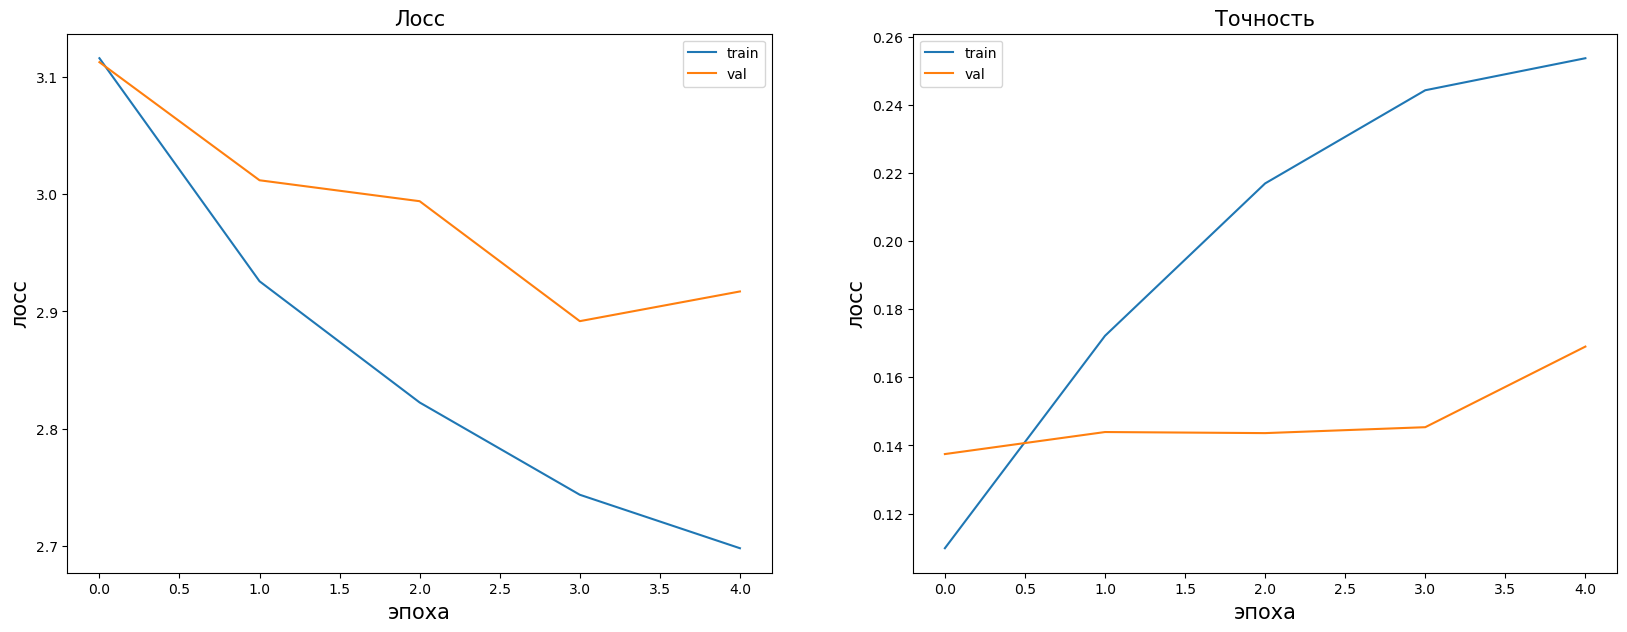

In [86]:
name = 'None'
fe_model = torchvision.models.resnet18(pretrained=True)
for param in fe_model.parameters():
    param.requires_grad = False

fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

In [87]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['features_extraction','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
59,fine_tuning,good,None,444.059954,0.01,4,0.163123,0.962125,0.261700,0.936395
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
44,fine_tuning,base,M&R,444.375121,[0.0001],4,0.113168,0.975092,0.290072,0.928662
58,fine_tuning,good,None,445.321584,0.01,3,0.230634,0.944927,0.301961,0.922980
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
43,fine_tuning,base,M&R,441.148812,[0.0001],3,0.181254,0.957884,0.316561,0.919350
57,fine_tuning,good,None,444.435946,0.01,2,0.339216,0.916598,0.356834,0.911774
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
42,fine_tuning,base,M&R,441.713238,[0.0001],2,0.296949,0.928763,0.364779,0.904987
56,fine_tuning,good,None,496.342083,0.01,1,0.564541,0.867010,0.466197,0.884943


### Обучение с Fine-tuning

Epoch 5 of 5 took 2080.274s
  training loss (in-iteration): 	0.890561
  validation loss (in-iteration): 	0.815751
  training accuracy: 			76.23 %
  validation accuracy: 			77.59 %


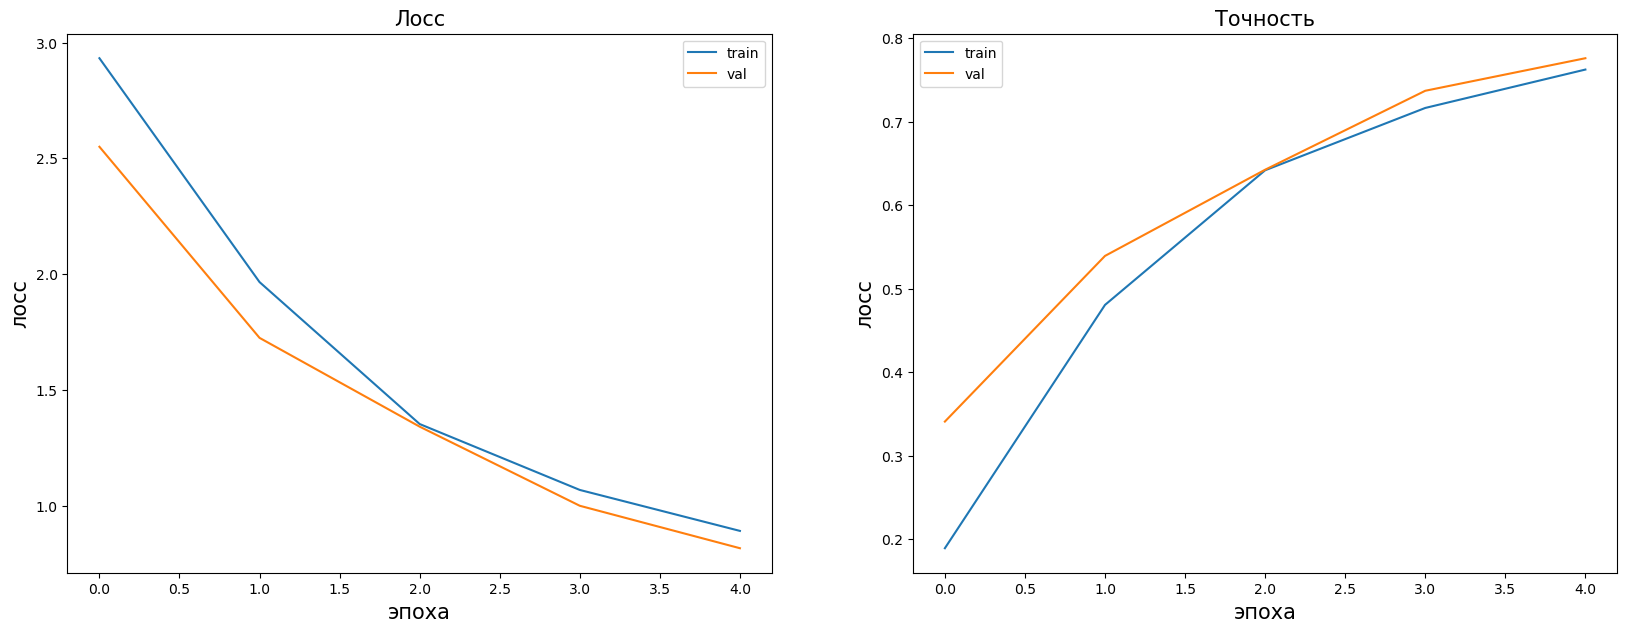

In [89]:
name='None'
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs, None, None
)

In [90]:
for i in range(num_epochs):
    result.loc[len(result.index)] = ['fine_tuning','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
59,fine_tuning,good,None,444.059954,0.01,4,0.163123,0.962125,0.261700,0.936395
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
44,fine_tuning,base,M&R,444.375121,[0.0001],4,0.113168,0.975092,0.290072,0.928662
58,fine_tuning,good,None,445.321584,0.01,3,0.230634,0.944927,0.301961,0.922980
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
43,fine_tuning,base,M&R,441.148812,[0.0001],3,0.181254,0.957884,0.316561,0.919350
57,fine_tuning,good,None,444.435946,0.01,2,0.339216,0.916598,0.356834,0.911774
42,fine_tuning,base,M&R,441.713238,[0.0001],2,0.296949,0.928763,0.364779,0.904987
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
56,fine_tuning,good,None,496.342083,0.01,1,0.564541,0.867010,0.466197,0.884943


### Итоги Bad Aug

Bad аугментация заключается в некорректных опциях, что значительно ухудшает качество модели. 

## Выводы

In [94]:
result.sort_values(by='val_accuracy', ascending=False)

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
59,fine_tuning,good,None,444.059954,0.01,4,0.163123,0.962125,0.261700,0.936395
34,fine_tuning,base,None,446.427624,0.01,4,0.119033,0.973792,0.288926,0.928819
44,fine_tuning,base,M&R,444.375121,[0.0001],4,0.113168,0.975092,0.290072,0.928662
58,fine_tuning,good,None,445.321584,0.01,3,0.230634,0.944927,0.301961,0.922980
33,fine_tuning,base,None,444.123797,0.01,3,0.186552,0.956329,0.314127,0.921402
43,fine_tuning,base,M&R,441.148812,[0.0001],3,0.181254,0.957884,0.316561,0.919350
57,fine_tuning,good,None,444.435946,0.01,2,0.339216,0.916598,0.356834,0.911774
42,fine_tuning,base,M&R,441.713238,[0.0001],2,0.296949,0.928763,0.364779,0.904987
32,fine_tuning,base,None,445.494031,0.01,2,0.303172,0.928698,0.378620,0.904987
56,fine_tuning,good,None,496.342083,0.01,1,0.564541,0.867010,0.466197,0.884943


In [95]:
result.groupby('augmentation')['val_accuracy'].nlargest(1).reset_index(level=1, drop=True).sort_values(ascending=False)

augmentation
good    0.936395
base    0.928819
bad     0.299874
Name: val_accuracy, dtype: float64

Несомненным лидером для улучшения качества модели является метод дообучения fine-tuning.
Правильно подобранные параметры аугментации улучшают качество модели, но в целом применение шедулера и аугментации не привело к существенному улучшению.